# **Recurrent Neural Network - Stock Prediction**

Le but de cet exercice est de prédire le cours de l'action Google. Rien que ça. Plus exactement : on veut prédire le prix de l'action Google à j+1 en utilisant un certain nombre de jours précédents. Allez en route !

## **1. Import et preprocessing des données**

1. Récupérer les données de Google sur Yahoo!Finance (c'est la colonne "close" qui nous intéressera). Prendre tout l'historique (depuis le 19 août 2004)
2. Pour vous rafraîchir un peu la mémoire :
>- les charger en un objet série temporelle avec pandas,
>- modifier la fréquence pour être en "jours ouvrables"
>- afficher la série
3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée
4. Scaler vos données. Pour les réseaux récurrents et plus généralement lorsqu'on utilise des fonctions d'activation sigmoïde, on suggère d'utiliser la normalisation (min-max)
5. Transformer vos données de sorte qu'elles puissent servir pour entraîner un réseau, c'est-à-dire qu'on veut une matrice X d'inputs et un vecteur y de targets. Pour ça, vous devez vous demander, qu'est-ce que je veux prédire et avec quoi ?
6. Quelle est la dimension des inputs pour un [réseau récurrent de keras](https://keras.io/api/layers/recurrent_layers/) (simple, LSTM, GRU, peu importe) ? Agissez en conséquence...c'est niquel ça fera même la transition avec la suite : lisez la doc, vous allez faire un RNN

## Exercice réalisé sur l'histo du Bitcoin 

In [30]:
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# modif taille des figures
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,8)

### 1. Recupération d'une serie d'extract de valeurs de fermeture bitcoin sur marché

In [ ]:
df = pd.read_csv("data/bitcoin_serie.csv")
df.drop("Unnamed: 0",axis=1, inplace=True)
## Convert to time series pandas
df['Date'] = pd.to_datetime(df['Date'])
## Set Date column to INdex
df = df.set_index("Date")

### 2. Modifier la fréquence pour être en "jours ouvrables"

In [ ]:
df = df.asfreq(BDay())
df.index

DatetimeIndex(['2010-07-19', '2010-07-20', '2010-07-21', '2010-07-22',
               '2010-07-23', '2010-07-26', '2010-07-27', '2010-07-28',
               '2010-07-29', '2010-07-30',
               ...
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', length=3075, freq='B')

In [ ]:
df

<AxesSubplot:xlabel='Date'>

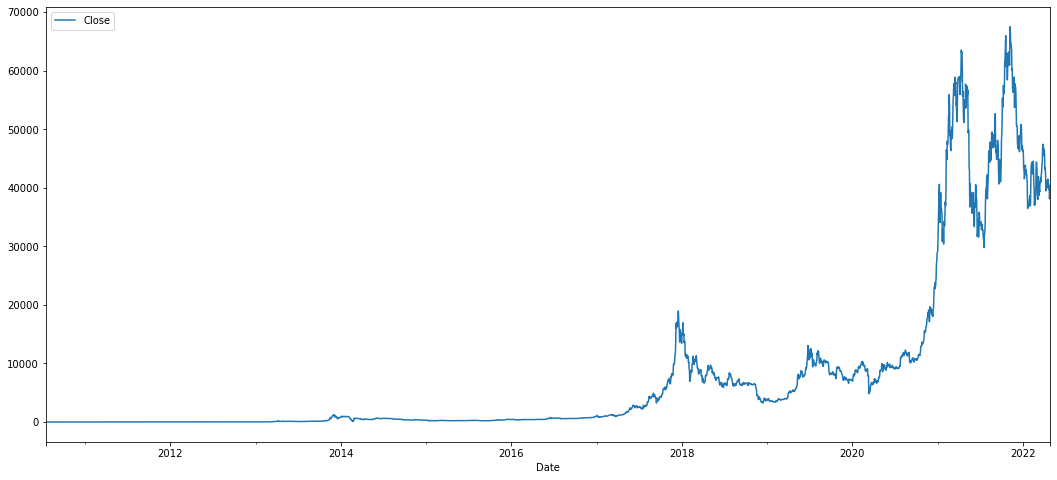

In [ ]:
df.plot()

#### On vérifie bien l'indexage de 0 à 4 pour aller du lundi au vendredi, puis repartir le lundi à index[5]

In [ ]:
df.index[0].strftime("%A"), df.index[5].strftime("%A")

('Monday', 'Monday')

### 3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée

#### Creating a Target
Lors de la formation d'un modèle d'apprentissage automatique supervisé, il est nécessaire d'avoir une cible. Une cible est définie comme l'objectif ou la caractéristique de l'ensemble de données que nous essayons de comprendre. Cela ne doit pas être confondu avec les étiquettes, qui sont des valeurs connues attribuées aux données. Pour ce projet, l'objectif était le prix du Bitecoin

L'ensemble de validation est utilisé pour évaluer le modèle une fois qu'il a été formé. Normalement, lors de la préparation des données, vous pouvez les mélanger et réserver une section aléatoire comme ensemble de validation. Mais ce projet utilise des données de séries chronologiques, il est donc plus logique de couper une section cohérente à la fin. J'ai pris les derniers 5% des données à utiliser pour l'ensemble de validation.

In [ ]:
# train et test sets
train = df.loc[:'2021']
test = df.loc['2022']

print(df.shape, train.shape, test.shape)
print(train.index[-5:])
print(test.index[:5])

(3075, 1) (2990, 1) (85, 1)
DatetimeIndex(['2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07'],
              dtype='datetime64[ns]', name='Date', freq='B')


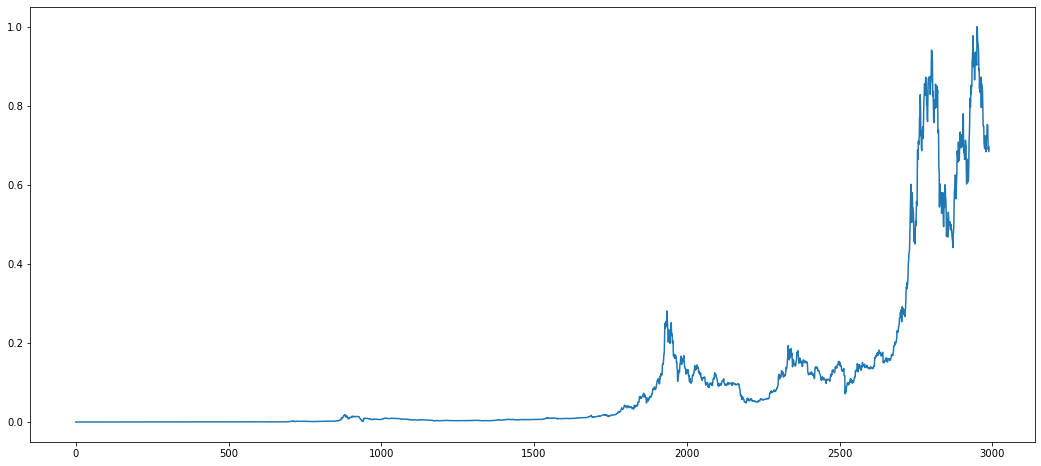

In [ ]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

### Making sequences
LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is:

## [batch_size, sequence_length, n_features]

In [ ]:
# Création de la structure des données avec un nombre fixé n de timesteps (de jours) et 1 output
# c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n jours précédents
timesteps = 40 #on crée un paramètre pour pouvoir le modifier facilement par la suite
X_train = []
y_train = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i, 0])
    y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2950, 40) (2950,)


In [ ]:
# Ajout d'une 3ème dimension à X_train
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(2950, 40, 1)

## **2. Construction du réseau**

1. Continuer de regarder un peu la doc `keras` sur les RNN pour savoir quelles couches utiliser
2. En reprenant toujours les mêmes étapes (initialisation, ajout de couches cachées, couche de sortie, paramètres d'entraînement, entraînement), construire un RNN comprenant plusieurs couches LSTM empilées.  
Ne pas oublier de gérer le sur-apprentissage s'il y en a...

In [39]:
# Initialisation
rnn = Sequential()

# 1ère couche LSTM
rnn.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2])))

# Output
rnn.add(Dense(units=1))

# Paramètres d'entraînement
rnn.compile(optimizer='adam', loss='mse')

# Structure du modèle
print(rnn.summary())

# Entraînement
rnn.fit(X_train, y_train, epochs=30, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
93/93 [==============================] - 1s 5ms/step - loss: 0.0043
Epoch 2/30
93/93 [==============================] - 1s 6ms/step - loss: 5.2597e-04
Epoch 3/30
93/93 [==============================] - 1s 6ms/step - loss: 4.3628e-04
Epoch 4/30
93/93 [==============================] - 1s 6ms/step - loss: 3.8226e-04
Epoch 5/30
93/93 [==============================] - 1s 6ms/step - loss: 3.4752e-04
Epoch 6/30
93/93 [==============================] - 1s 6ms/step - loss: 3.4289e-04
Epoch 7/30
93/9

In [45]:
# Comme on dirait que ça n'a pas convergé, on va continuer un peu l'entraînement
# On répète me l'opération un certain nombre de fois
rnn.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
93/93 [==============================] - 1s 5ms/step - loss: 1.5571e-04
Epoch 2/30
93/93 [==============================] - 0s 5ms/step - loss: 1.4879e-04
Epoch 3/30
93/93 [==============================] - 1s 5ms/step - loss: 1.5869e-04
Epoch 4/30
93/93 [==============================] - 1s 5ms/step - loss: 1.3915e-04
Epoch 5/30
93/93 [==============================] - 0s 5ms/step - loss: 1.5312e-04
Epoch 6/30
93/93 [==============================] - 0s 5ms/step - loss: 1.4418e-04
Epoch 7/30
93/93 [==============================] - 0s 5ms/step - loss: 1.4686e-04
Epoch 8/30
93/93 [==============================] - 1s 5ms/step - loss: 1.5041e-04
Epoch 9/30
93/93 [==============================] - 1s 6ms/step - loss: 1.4012e-04
Epoch 10/30
93/93 [==============================] - 0s 5ms/step - loss: 1.3971e-04
Epoch 11/30
93/93 [==============================] - 0s 5ms/step - loss: 1.3602e-04
Epoch 12/30
93/93 [==============================] - 1s 5ms/step - loss: 1.2938e-04
E

## **3. Prédiction, évaluation et visualisation**

**Première approche :** une première méthode est de prédire chaque jour à partir des dernières vraies valeurs. Cela a du sens puisque notre modèle est construit pour ça : prédire la valeur de l'action à j+1 à partir d'un nombre de jours précédents fixés. En revanche cela veut dire qu'on utilise à chaque fois les vraies valeurs de l'échantillon test pour prédire la suivante. Pour essayer d'être plus clair :  
>- on a un modèle entraîné avec les données jusqu'au 31/08/2020 et on veut prédire les valeurs du 01/09/2020 au 13/11/2020
>- notre modèle est fait pour prédire un jour à partir des précédents, le 31/08 on va donc prédire le 01/09 à partir des données des jours précédents
>- ensuite, le lendemain, le 01/09, on va prédire le 02/09 en utilisant la vraie valeur du 01/09 qu'on aura observée depuis ainsi que les précédentes
>- ensuite, le lendemain, le 02/09, on va prédire le 03/09 en utilisant les vraies valeurs des 01/09 et 02/09 et les précédentes
>- etc...
>
> Ce qu'on peut reprocher à cette méthode c'est de ne pas utiliser les nouvelles infos dans la construction du modèle mais uniquement pour la prédiction. Ça a un petit côté paradoxal mais en même temps on a pas forcément envie de réentraîner notre modèle tous les jours avec juste une seule valeur en plus.
>
>1. Le premier travail va être de formater les inputs de test pour qu'ils soient au même format que ceux de l'entraînement du modèle. Il faut donc répéter les opérations qu'on a faites pour le train. Avec quelques modifications quand même. hésitez pas à prendre un papier un crayon si ça chauffe trop...
>>- définir un objet `inputs` qui contient toutes les valeurs dont vous aurez besoin (donc les données du test + les n dernières valeurs du train nécessaires à la prédiction des n premières valeurs du test). Vous pouvez pour ça utiliser certaines méthodes des objets datetime de pandas.
>>- une fois que c'est fait, il vous reste plus qu'à normaliser et reconstruire votre `X_test` de la même manière que votre `X_train`
>2. Évaluer les prédictions avec une ou plusieurs métriques adaptées
>3. Afficher les prédictions sur un beau graphique

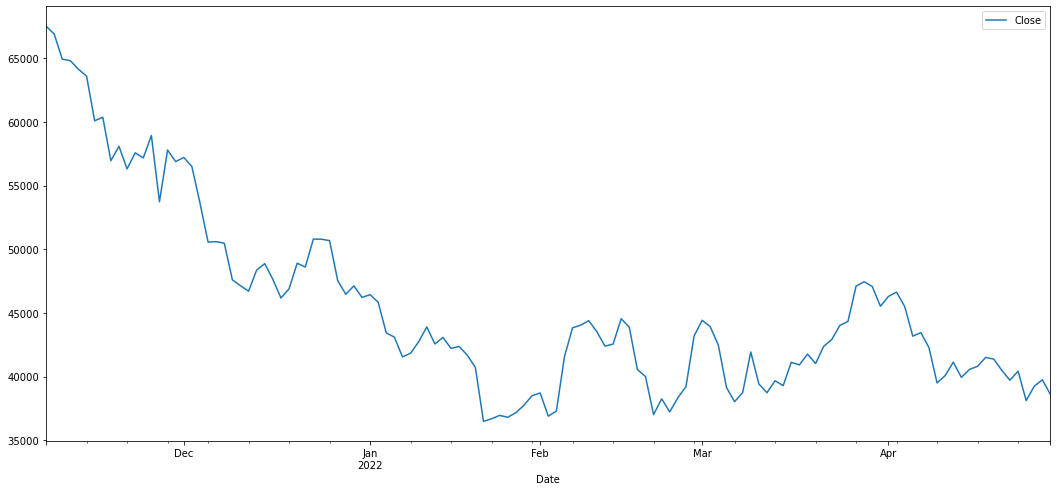

In [52]:
inputs = df[pd.date_range(end=test.index[0], periods=timesteps+1, freq='B')[0]:]
inputs.plot();

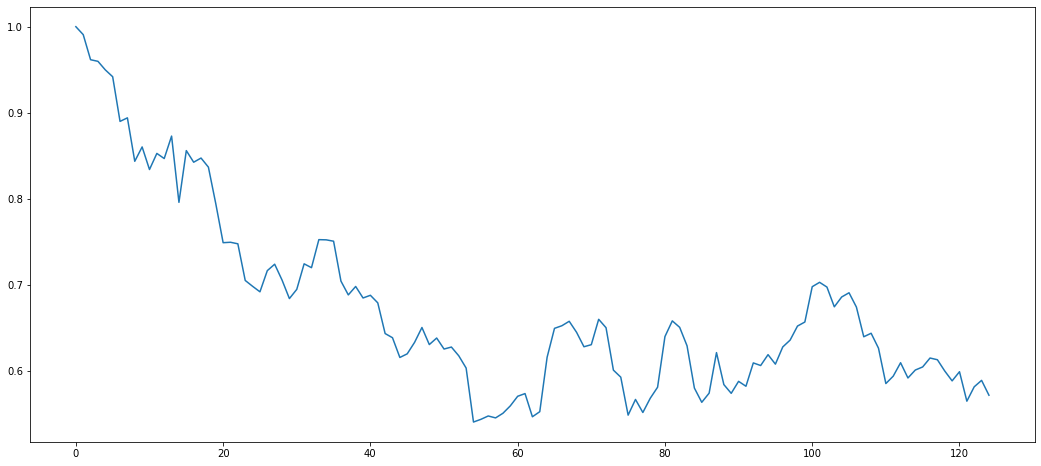

In [53]:
inputs = sc.transform(inputs)
plt.plot(inputs);

In [54]:
X_test = []
y_test = []

for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i, 0])
X_test = np.expand_dims(X_test, axis=2)
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(85, 40, 1) (85,)


In [55]:
# prediction
y_pred = rnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred)

In [56]:
# évaluation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
RMSE = sqrt(mean_squared_error(y_pred, test))
nRMSE = RMSE/np.mean(test.values)
MAE = mean_absolute_error(y_pred, test)
nMAE = MAE/np.mean(test.values)
print(f"{RMSE=}\n{nRMSE=}\n{MAE=}\n{nMAE=}")

RMSE=1553.7269469064624
nRMSE=0.037529997940886475
MAE=1159.9687224264705
nMAE=0.028018838091748027


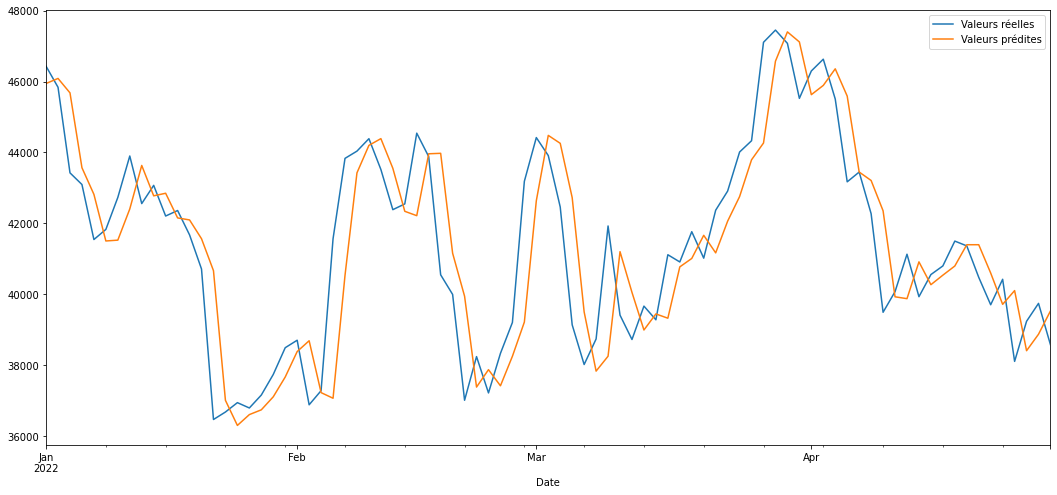

In [57]:
# Visualisation
y_df = test.copy().rename(columns={'Close':'Valeurs réelles'})
y_df['Valeurs prédites'] = y_pred
y_df.plot();

# Autre approche -> Many To Many 

Pour cette nouvelle approche, on va devoir reconstitué différement nos X et y, afin cette fois de ne plus ciblé une seule date pour la prediction,
mais bien un ensemble de dates . Pour l'approche, nous partirons sur 20 jours, l'équivalent d'un mois ouvrable ... 

### 3.3 Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée

L'ensemble de validation est utilisé pour évaluer le modèle une fois qu'il a été formé. Normalement, lors de la préparation des données, vous pouvez les mélanger et réserver une section aléatoire comme ensemble de validation. Mais ce projet utilise des données de séries chronologiques, il est donc plus logique de couper une section cohérente à la fin. J'ai pris les derniers 5% des données à utiliser pour l'ensemble de validation.

In [71]:
## Check Versions of libs 
from platform import python_version
import tensorflow as tf
import numpy
import keras

print(numpy.__version__)
print(tf.__version__)
print(keras.__version__)
print(python_version())

1.19.5
2.6.0
2.6.0
3.9.9


In [87]:
df = pd.read_csv("data/bitcoin_serie.csv")
df.drop("Unnamed: 0",axis=1, inplace=True)
## Convert to time series pandas
df['Date'] = pd.to_datetime(df['Date'])
## Set Date column to INdex
df = df.set_index("Date")

### 2. Modifier la fréquence pour être en "jours ouvrables"

In [88]:
df = df.asfreq(BDay())
df.index

DatetimeIndex(['2010-07-19', '2010-07-20', '2010-07-21', '2010-07-22',
               '2010-07-23', '2010-07-26', '2010-07-27', '2010-07-28',
               '2010-07-29', '2010-07-30',
               ...
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', length=3075, freq='B')

In [90]:
df.shape

(3075, 1)

<AxesSubplot:xlabel='Date'>

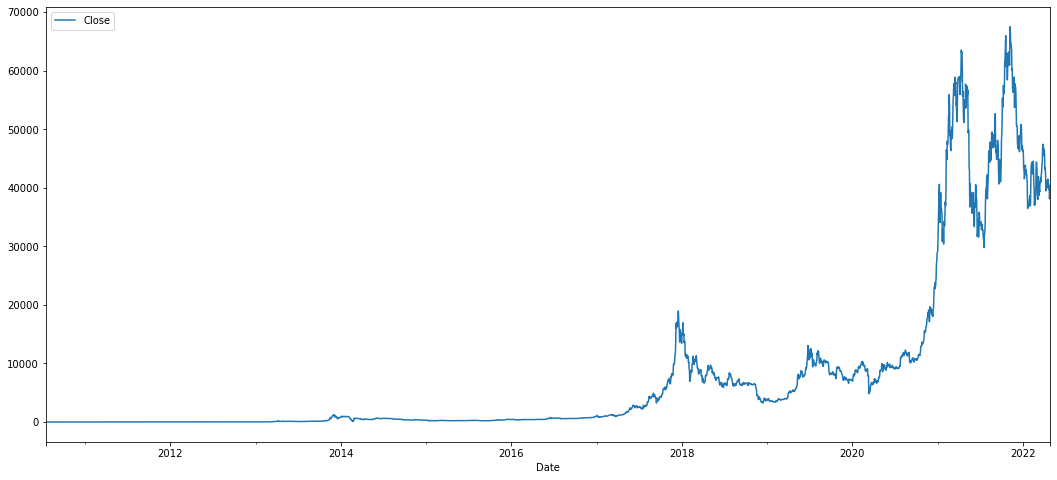

In [91]:
df.plot()

#### On vérifie bien l'indexage de 0 à 4 pour aller du lundi au vendredi, puis repartir le lundi à index[5]

In [92]:
df.index[0].strftime("%A"), df.index[5].strftime("%A")

('Monday', 'Monday')

### 3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée

#### Creating a Target
Lors de la formation d'un modèle d'apprentissage automatique supervisé, il est nécessaire d'avoir une cible. Une cible est définie comme l'objectif ou la caractéristique de l'ensemble de données que nous essayons de comprendre. Cela ne doit pas être confondu avec les étiquettes, qui sont des valeurs connues attribuées aux données. Pour ce projet, l'objectif était le prix du Bitecoin

L'ensemble de validation est utilisé pour évaluer le modèle une fois qu'il a été formé. Normalement, lors de la préparation des données, vous pouvez les mélanger et réserver une section aléatoire comme ensemble de validation. Mais ce projet utilise des données de séries chronologiques, il est donc plus logique de couper une section cohérente à la fin. J'ai pris les derniers 5% des données à utiliser pour l'ensemble de validation.

In [93]:
# train et test sets
train = df.loc[:'2021']
test = df.loc['2022']

print(df.shape, train.shape, test.shape)
print(train.index[-5:])
print(test.index[:5])

(3075, 1) (2990, 1) (85, 1)
DatetimeIndex(['2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07'],
              dtype='datetime64[ns]', name='Date', freq='B')


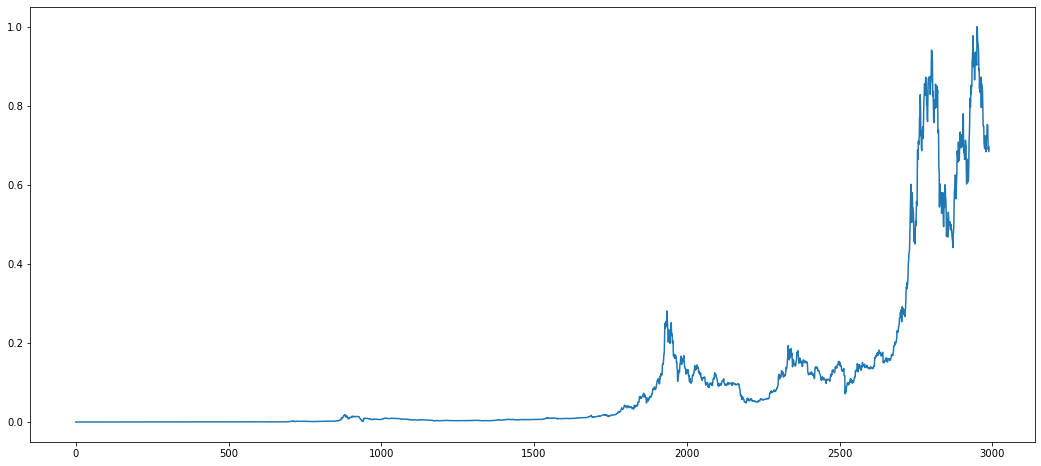

In [94]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

In [96]:
# Création de la structure des données avec un nombre fixé n de timesteps (de jours) et 1 output
# c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n jours précédents
timesteps = 40 #on crée un paramètre pour pouvoir le modifier facilement par la suite
ndays=20
X_train = []
y_train = []

for i in range(timesteps, train.shape[0]-ndays):
    X_train.append(train[i-timesteps:i, 0])
    y_train.append(train[i:i+ndays, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2930, 40) (2930, 20)


In [97]:
# Ajout d'une 3ème dimension à X_train
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(2930, 40, 1)

In [102]:
# Initialisation
rnn = Sequential()

# 1ère couche LSTM
rnn.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), unroll = True)) # paramètre pour CPU

# Output
rnn.add(Dense(units=ndays))

# Paramètres d'entraînement
rnn.compile(optimizer='adam', loss='mse')

# Structure du modèle
print(rnn.summary())

# Entraînement
rnn.fit(X_train, y_train, epochs=30, batch_size=32)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
Total params: 4,460
Trainable params: 4,460
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
92/92 [==============================] - 2s 3ms/step - loss: 0.0191
Epoch 2/30
92/92 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/30
92/92 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/30
92/92 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 5/30
92/92 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 6/30
92/92 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/30
92/92 [=================

In [103]:
# Comme on dirait que ça n'a pas convergé, on va continuer un peu l'entraînement
# On répète me l'opération un certain nombre de fois
rnn.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
92/92 [==============================] - 0s 2ms/step - loss: 8.8619e-04
Epoch 2/30
92/92 [==============================] - 0s 2ms/step - loss: 9.0851e-04
Epoch 3/30
92/92 [==============================] - 0s 2ms/step - loss: 8.5933e-04
Epoch 4/30
92/92 [==============================] - 0s 2ms/step - loss: 8.5124e-04
Epoch 5/30
92/92 [==============================] - 0s 2ms/step - loss: 9.6736e-04
Epoch 6/30
92/92 [==============================] - 0s 2ms/step - loss: 9.4715e-04
Epoch 7/30
92/92 [==============================] - 0s 2ms/step - loss: 8.9998e-04
Epoch 8/30
92/92 [==============================] - 0s 2ms/step - loss: 8.5502e-04
Epoch 9/30
92/92 [==============================] - 0s 2ms/step - loss: 8.4440e-04
Epoch 10/30
92/92 [==============================] - 0s 2ms/step - loss: 8.2942e-04
Epoch 11/30
92/92 [==============================] - 0s 2ms/step - loss: 8.2514e-04
Epoch 12/30
92/92 [==============================] - 0s 2ms/step - loss: 8.3864e-04
E

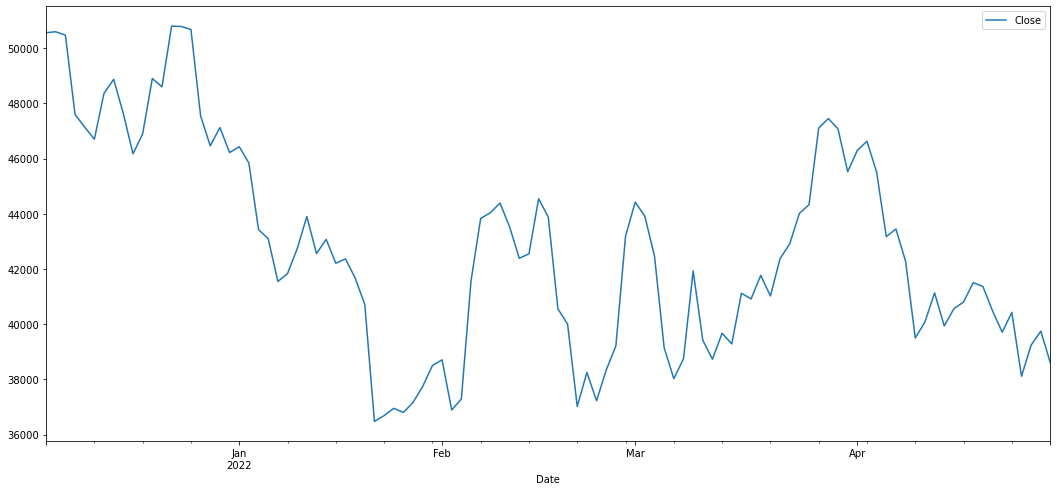

In [112]:
day_first = pd.date_range(end=test.index[0], periods=ndays+1, freq='B')[0]
#day_end = pd.date_range(end=test.index[-1], periods=ndays+1, freq='B')[0]

inputs = df[day_first:]
inputs.plot();

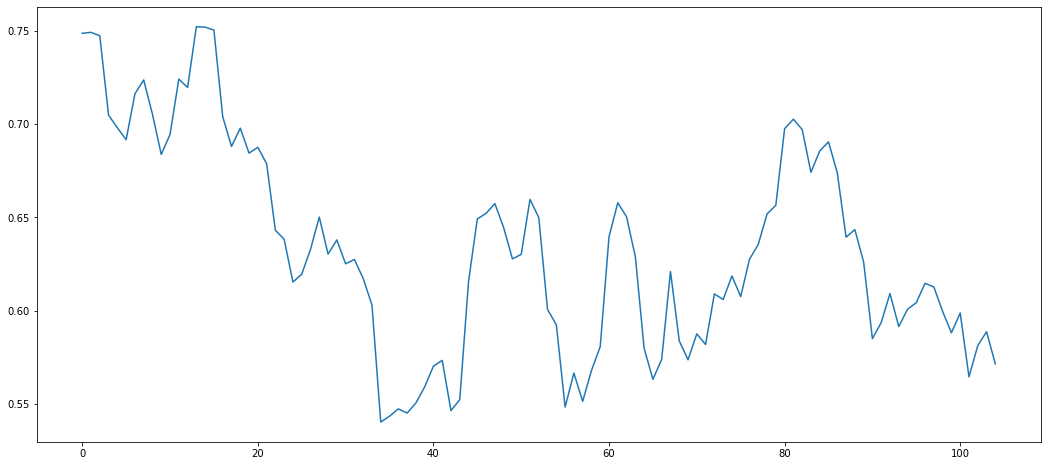

In [113]:
inputs = sc.transform(inputs)
plt.plot(inputs);

In [116]:
X_test = []
y_test = []

for i in range(timesteps, len(inputs)-ndays):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i:i+ndays, 0])
X_test = np.expand_dims(X_test, axis=2)
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(45, 40, 1) (45, 20)


In [119]:
# prediction
y_pred = rnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
#plt.plot(y_pred);

## **4. Amélioration du modèle**

En revenant sur la première approche, essayer d'amélorier le modèle.

Quelques pistes qui peuvent évidemment être combinées mais tout ça étant coûteux en temps, vous ne pourrez pas tout tester :
- Plus de données, quand c'est possible
- Augmenter le nombre de "timesteps" pour regarder plus loin dans le passé
- Ajouter d'autres variables : par exemple on pourrait ajouter des actions d'autres entreprises dont l'action pourrait être corrélée à celle de Google
- Compléxifier le réseau : plus de couches/neurones
- Ajustement des hyperparamètres

In [ ]:
df2 = pd.read_csv("data/bitcoin_full_serie.csv")
df2.drop("Unnamed: 0",axis=1, inplace=True)

## Convert to time series pandas
df2['Date'] = pd.to_datetime(df2['Date'])

## Set Date column to INdex
df2 = df2.set_index("Date")

### 2. Modifier la fréquence pour être en "jours ouvrables"

In [134]:
df2 = df2.asfreq(BDay())
df2.index

DatetimeIndex(['2010-07-19', '2010-07-20', '2010-07-21', '2010-07-22',
               '2010-07-23', '2010-07-26', '2010-07-27', '2010-07-28',
               '2010-07-29', '2010-07-30',
               ...
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='Date', length=3075, freq='B')

#### On vérifie bien l'indexage de 0 à 4 pour aller du lundi au vendredi, puis repartir le lundi à index[5]

In [ ]:
df.index[0].strftime("%A"), df.index[5].strftime("%A")

('Monday', 'Monday')

### 3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée

#### Creating a Target
Lors de la formation d'un modèle d'apprentissage automatique supervisé, il est nécessaire d'avoir une cible. Une cible est définie comme l'objectif ou la caractéristique de l'ensemble de données que nous essayons de comprendre. Cela ne doit pas être confondu avec les étiquettes, qui sont des valeurs connues attribuées aux données. Pour ce projet, l'objectif était le prix du Bitecoin

L'ensemble de validation est utilisé pour évaluer le modèle une fois qu'il a été formé. Normalement, lors de la préparation des données, vous pouvez les mélanger et réserver une section aléatoire comme ensemble de validation. Mais ce projet utilise des données de séries chronologiques, il est donc plus logique de couper une section cohérente à la fin. J'ai pris les derniers 5% des données à utiliser pour l'ensemble de validation.

In [136]:
# train et test sets
train = df2.loc[:'2021']
test = df2.loc['2022']

print(df.shape, train.shape, test.shape)
print(train.index[-5:])
print(test.index[:5])

(3075, 1) (2990, 3) (85, 3)
DatetimeIndex(['2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31'],
              dtype='datetime64[ns]', name='Date', freq='B')
DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07'],
              dtype='datetime64[ns]', name='Date', freq='B')


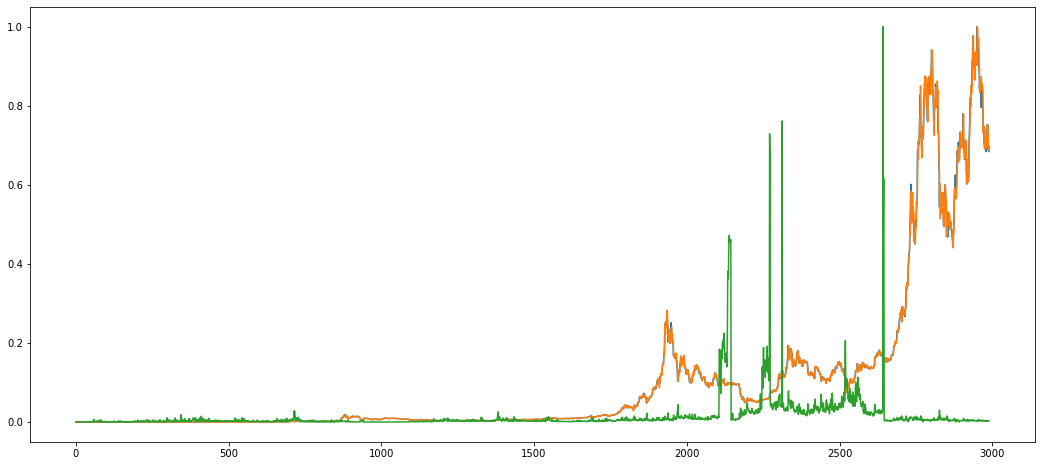

In [137]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

### Making sequences
LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is:

## [batch_size, sequence_length, n_features]

In [140]:
# Création de la structure des données avec un nombre fixé n de timesteps (de jours) et 1 output
# c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n jours précédents
timesteps = 30 #on crée un paramètre pour pouvoir le modifier facilement par la suite
X_train = []
y_train = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i, :])
    y_train.append(train[i, 2])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2960, 30, 3) (2960,)


In [ ]:
# Initialisation
model = Sequential()

# 1ère couche LSTM
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), unroll = True)) # paramètre pour CPU

# Output
model.add(Dense(units=ndays))

# Paramètres d'entraînement
model.compile(optimizer='adam', loss='mse')

# Structure du modèle
print(model.summary())

# Entraînement
model.fit(X_train, y_train, epochs=305, batch_size=32)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
Total params: 11,820
Trainable params: 11,820
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/305
93/93 [==============================] - 2s 3ms/step - loss: 0.0023
Epoch 2/305
93/93 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 3/305
93/93 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 4/305
93/93 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 5/305
93/93 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/305
93/93 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/305
93/93 [========

## **5. Ajout de variables supplémentaires**

Comme évoqué, on pourrait vouloir ajouter d'autres variables pour améliorer les performances de notre modéle. Dans cette partie, il s'agit de mettre en oeuvre un RNN avec plusieurs variables. Sans aller chercher l'action d'une autre entreprise des GAFA par exemple, on va se contenter pour simplifier ici d'uitiliser les autres variables disponibles dans le dataset (Open, High et Low).

1. À vous de modifier votre code pour prendre en compte dans votre modèle les 4 informations Open, High, Low et Close.
2. Comparer les prédictions obtenues (et les temps d'exécution !)

In [142]:
df = pd.read_csv('data/bitcoin_full_serie.csv', usecols=['Date','Open', 'High', 'Low', 'Close'], index_col='Date', parse_dates=True)
df = df.asfreq('B', method="ffill")
df.tail()

,Open,High,Low,Close
Date,,,,
2022-04-25,39464.0,40599.0,38233.0,40427.0
2022-04-26,40443.0,40770.0,37708.0,38113.0
2022-04-27,38113.0,39447.0,37869.0,39243.0
2022-04-28,39243.0,40382.0,38888.0,39748.0
2022-04-29,39748.0,39919.0,38175.0,38581.0


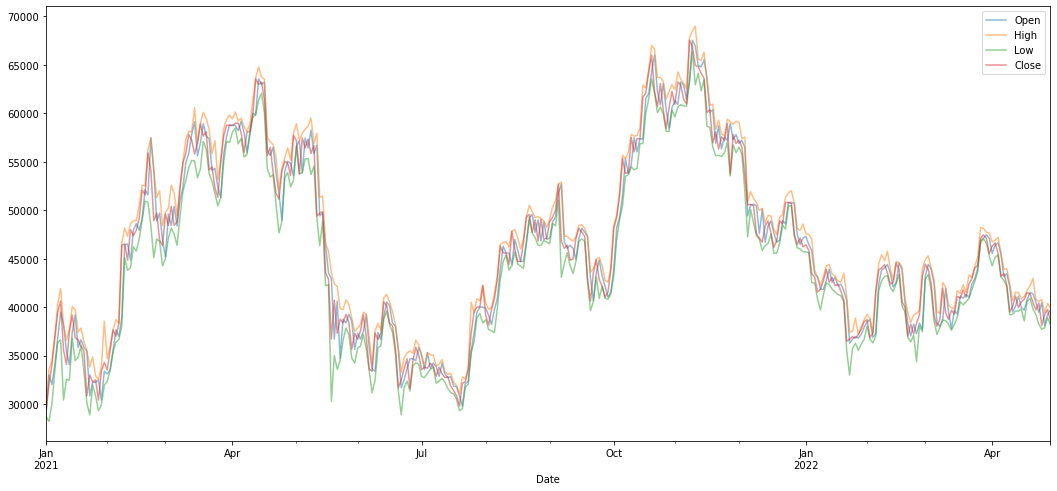

In [143]:
df['2021':].plot(alpha=0.5);

In [144]:
# train et test sets
train = df.loc[:'2021']
test = df.loc['2022']
print(df.shape, train.shape, test.shape)

(3075, 4) (2990, 4) (85, 4)


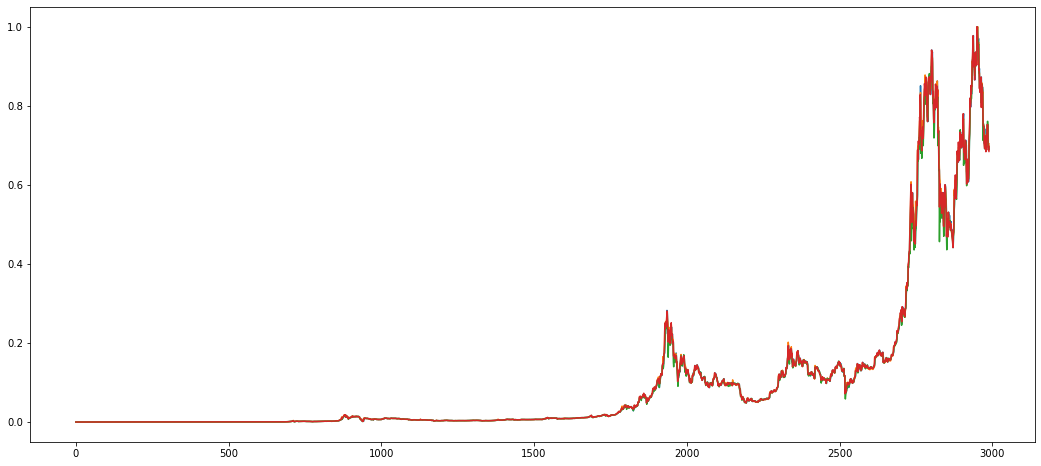

In [145]:
# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
plt.plot(train);

In [146]:
# Création de la structure des données avec un nombre fixé n de timesteps
# et 1 output c'est à dire qu'on va prédire la valeur de l'action pour 1 jour
# à partir des n précédents
timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, train.shape[0]):
    y_train.append(train[i, 3])
    X_train.append(train[i-timesteps:i, :])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2960, 30, 4) (2960,)


In [147]:
# Modèle RNN
model = Sequential()

model.add(LSTM(units = 30,
               input_shape = (X_train.shape[1], X_train.shape[2])))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
93/93 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: 3.8794e-04
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 3.3904e-04
Epoch 4/50
93/93 [==============================] - 0s 4ms/step - loss: 3.1351e-04
Epoch 5/50
93/93 [==============================] - 0s 4ms/step - loss: 2.7543e-04
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 2.5063e-04
Epoch 7/50
93/93 [==============================] - 0s 4ms/step - loss: 2.3707e-04
Epoch 8/50
93/93 [==============================] - 0s 4ms/step - loss: 2.2261e-04
Epoch 9/50
93/93 [==============================] - 0s 4ms/step - loss: 2.2426e-04
Epoch 10/50
93/93 [==============================] - 0s 4ms/step - loss: 2.0962e-04
Epoch 11/50
93/93 [==============================] - 0s 4ms/step - loss: 1.9172e-04
Epoch 12/50
93/93 [==============================] - 0s 4ms/step - loss: 1.9688e-04
Epoch

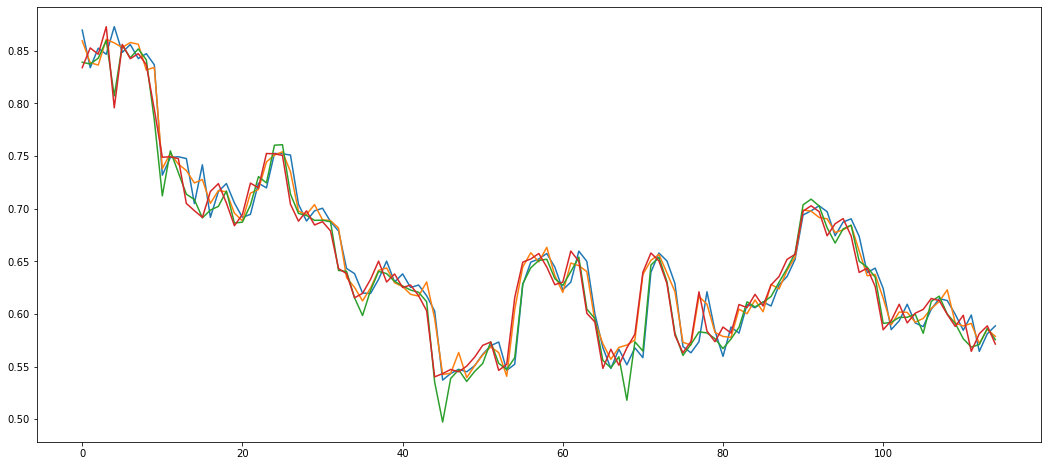

In [148]:
day_first = pd.date_range(end=test.index[0], periods=timesteps+1, freq='B')[0]
inputs = df[day_first:]
inputs = sc.transform(inputs)
plt.plot(inputs);

In [149]:
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i,:])
X_test = np.array(X_test)
print(X_test.shape)

(85, 30, 4)


In [150]:
#predictions
y_pred = model.predict(X_test)

In [151]:
# Le sc a été fitté sur une matrice a 4 colonnes donc pour revenir aux vraies valeurs grace à inverse_transform il faut :
# - soit créer une matrice intermédiaire à 4 colonnes avec y_pred en 4ème colonne (colonne Close), faire l'inverse_transform puis récupérer les valeurs
# - soit fitter un nouveau transformer uniquement sur la colonne Close du train et faire l'inverse_transform sur y_pred
mat = np.zeros((y_pred.shape[0], 4))
mat[:, 3] = y_pred[:,0]
mat = sc.inverse_transform(mat)
y_pred = mat[:,3]

In [152]:
# Évaluation : RMSE et RMSE normalisé (ou relatif)
import math
from sklearn.metrics import mean_squared_error
y_real = test.Close.values
RMSE = sqrt(mean_squared_error(y_pred, y_real))
nRMSE = RMSE/np.mean(y_real)
MAE = mean_absolute_error(y_pred, y_real)
nMAE = MAE/np.mean(y_real)
print(f"{RMSE=}\n{nRMSE=}\n{MAE=}\n{nMAE=}")

RMSE=1998.314471512314
nRMSE=0.04826893049027857
MAE=1572.754435390019
nMAE=0.037989603539559984
